- Leaving the account is deemed as a sell
- Entering the account is deemed as a buy

`ideas:`
- Volume of transactions in one day compared to the magnitude of price difference from MATIC token price. (Can increase the number of wallets that transaction data is being pulled from...)
- Magnitude for buying and selling in a day to the up or down movement of the Openn or CLose for the daily crypto price

Get crypto price data from yahoo finance: https://medium.com/geekculture/3-simple-ways-to-obtain-cryptocurrency-data-in-python-f45b9d603a97 


`Argument ---	   Description`
- ticker ---	       supply the ticker information which you want to return (str).
- granularity ---	   please supply a granularity in seconds (60, 300, 900, 3600, 21600, 86400) (int).
- start_date ---	   a string in the format YYYY-MM-DD-HH-MM (str).
- end_date ---	   a string in the format YYYY-MM-DD-HH-MM (str). Optional, Default: Now
- verbose ---	       printing during extraction. Default: True

# 1. Import Libraries

In [2]:
from Historic_Crypto import HistoricalData as HD
import pandas as pd
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt
import scipy

# 2. Etherscan API Call

In [3]:
def etherScanAPICall(wallet_address):
    API_KEY = 'JATAZ8XWIBGBTY15YJJEABCDPIF8SCK7S3'
    MATIC_CONTRACT_ADDRESS = '0x7D1AfA7B718fb893dB30A3aBc0Cfc608AaCfeBB0'
    # WALLET_ADDRESS = '0x9507c04b10486547584c37bcbd931b2a4fee9a41'
    url = 'https://api.etherscan.io/api?'

    parameters = {
        'module':'account',
        'action':'tokentx',
        'contractaddress':MATIC_CONTRACT_ADDRESS,
        'address':wallet_address,
        'page':'1',
        'offset':'10000',
        'startblock':'0',
        'endblock':'27025780',
        'sort':'asc',
        'apikey':API_KEY
    }

    responseJSON = requests.request("GET", url, params=parameters).json()

    print("# of Transactions:",len(responseJSON.get("result")))

    with open("transactionsResponse.json", "w") as write_file:
        json.dump(responseJSON, write_file, indent=4, sort_keys = True)

    return responseJSON

In [4]:
def etherScanAPI_MultiWallet_Call(listOfWalletAddresses):

    totalTransactionDataList = []

    for wallet in listOfWalletAddresses:
        walletTransactionData = etherScanAPICall(wallet)
        totalTransactionDataList = totalTransactionDataList + walletTransactionData.get("result")

    return totalTransactionDataList

In [5]:
listOfWallets = [
    '0x9507c04b10486547584c37bcbd931b2a4fee9a41',
    '0x5666ed92c83af9dab61601c87bf7769ad57103f9',
    '0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0',
    '0xed28b1c47375cd23aa6428544f4feaeaf3ee4e7b',
    '0x5e3ef299fddf15eaa0432e6e66473ace8c13d908',
    '0x401f6c983ea34274ec46f84d70b31c151321188b', 
    '0xcd6507d87f605f5e95c12f7c4b1fc3279dc944ab', 
    '0xb316fa9fa91700d7084d377bfdc81eb9f232f5ff',
    '0x50d669f43b484166680ecc3670e4766cdb0945ce'
]

In [6]:
rawTransactionData = etherScanAPI_MultiWallet_Call(listOfWallets)

# of Transactions: 2748
# of Transactions: 739
# of Transactions: 506
# of Transactions: 3
# of Transactions: 10000
# of Transactions: 10000
# of Transactions: 90
# of Transactions: 267
# of Transactions: 6


In [7]:
# print(rawTransactionData)

buying and Selling

In [8]:
def wei_to_ether(wei):
    ether = wei / (10**18)
    return ether

In [9]:
def convert_UNIX_to_DateTime(unix):
    return datetime.utcfromtimestamp(int(unix)).strftime('%Y-%m-%d %H:%M:%S') # returns type str

In [10]:
dateTo_buyAndSellVolume = {}

for transaction in rawTransactionData:

    timeStamp = convert_UNIX_to_DateTime(transaction.get("timeStamp"))
    timeStamp = timeStamp[0:10]

    value = wei_to_ether(float(transaction.get("value")))
    
    to_wallet = transaction.get("to")
    from_wallet = transaction.get("from")

    # print(timeStamp, value, to_wallet, from_wallet)

    if timeStamp in dateTo_buyAndSellVolume:
        # considered a sell
        if from_wallet in listOfWallets:
            dateTo_buyAndSellVolume[timeStamp] -= value
        # considered a buy
        elif to_wallet in listOfWallets:
            dateTo_buyAndSellVolume[timeStamp] += value
    else:
        # considered a sell
        if from_wallet in listOfWallets:
            dateTo_buyAndSellVolume[timeStamp] = value
        # considered a buy
        elif to_wallet in listOfWallets:
            dateTo_buyAndSellVolume[timeStamp] = value

# print(dateTo_buyAndSellVolume)

# 3. 

{'blockNumber': '16091175', 
'timeStamp': '1669912427', 
'hash': '0xd74c3f3e1b6a05731e3b8eda20a6c1d98a1f4dbbaaa9931d210d031af8ec4456', 
'nonce': '102', 
'blockHash': '0x0d945fd54ccd865c450fe73d94110f377315815465f1a33c39ca654cb0ace02b', 
'from': '0xed28b1c47375cd23aa6428544f4feaeaf3ee4e7b', 
'contractAddress': '0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0', 
'to': '0x5e3ef299fddf15eaa0432e6e66473ace8c13d908', 
'value': '50100000000000000000', 
'tokenName': 'Matic Token', 
'tokenSymbol': 'MATIC', 
'tokenDecimal': '18', 
'transactionIndex': '49', 
'gas': '254199', 
'gasPrice': '20820448945', 
'gasUsed': '221634', 
'cumulativeGasUsed': '4805006', 
'input': 'deprecated', 
'confirmations': '61052'}

In [11]:
def getStartAndEndDate(transactionData):

    startDate = 99999999999
    endDate = 0

    for transaction in transactionData:
        timeStamp = int(transaction.get('timeStamp'))

        if timeStamp < startDate:
            startDate = timeStamp
        elif timeStamp > endDate:
            endDate = timeStamp

    return startDate, endDate

In [12]:
startDate, endDate = getStartAndEndDate(rawTransactionData)
print(startDate, endDate)
startDate = str(convert_UNIX_to_DateTime(startDate))[0:10]
endDate = str(convert_UNIX_to_DateTime(endDate))[0:10]
print(startDate, endDate)

1555781762 1670685071
2019-04-20 2022-12-10


In [13]:
def getDailyTransactionVolumeForListOfWallets(transactionData):
    dailyTransactionVolume = {}

    for transaction in transactionData:
        timeStamp = convert_UNIX_to_DateTime(transaction.get("timeStamp"))
        timeStamp = timeStamp[0:10]
        if (timeStamp in dailyTransactionVolume):
            cnt = dailyTransactionVolume.get(timeStamp) + 1
            dailyTransactionVolume[timeStamp] = cnt
        else:
            dailyTransactionVolume[timeStamp] = 1


    ordered_data = sorted(dailyTransactionVolume.items(), key = lambda x:datetime.strptime(x[0],'%Y-%m-%d'), reverse=False)

    # print(type(ordered_data))
    # print(type(dict(ordered_data)))
    # print(dict(ordered_data))

    return dict(ordered_data)

In [14]:
dailyTransactionVolume = getDailyTransactionVolumeForListOfWallets(rawTransactionData)

In [15]:
# print(dailyTransactionVolume)

In [16]:
def getCryptoHistoricalData(token, startDate, endDate):
    data = HD(token,86400,startDate+"-00-00",endDate+"-00-00").retrieve_data()
    data.to_csv('tokenPriceData.csv')
    return data

In [17]:
rawTokenData = getCryptoHistoricalData('MATIC-USD', startDate, endDate)

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'MATIC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2019-04-20T00:00:00
Provisional End: 2020-02-14T00:00:00
Data for chunk 1 of 5 extracted
CoinBase Pro API did not have available data for 'MATIC-USD' beginning at 2019-04-20-00-00.  
                        Trying a later date:'2019-04-20T00:00:00'
Provisional Start: 2020-02-14T00:00:00
Provisional End: 2020-12-10T00:00:00
Data for chunk 2 of 5 extracted
CoinBase Pro API did not have available data for 'MATIC-USD' beginning at 2019-04-20-00-00.  
                        Trying a later date:'2020-02-14T00:00:00'
Provisional Start: 2020-12-10T00:00:00
Provisional End: 2021-10-06T00:00:00
Data for chunk 3 of 5 extracted


/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2021-10-06T00:00:00
Provisional End: 2022-08-02T00:00:00
Data for chunk 4 of 5 extracted
Provisional Start: 2022-08-02T00:00:00
Provisional End: 2023-05-29T00:00:00
Data for chunk 5 of 5 extracted


In [18]:
print(rawTokenData)

               low    high    open   close       volume
time                                                   
2021-03-11  0.3140  0.5900  0.3871  0.4243  226442305.9
2021-03-12  0.3924  0.5376  0.4249  0.4149  399949092.9
2021-03-13  0.4097  0.4694  0.4146  0.4249  173058984.7
2021-03-14  0.3727  0.4385  0.4263  0.3812  118930211.9
2021-03-15  0.3781  0.4300  0.3812  0.3909  115608670.0
...            ...     ...     ...     ...          ...
2022-12-06  0.8965  0.9214  0.9117  0.9176   25489220.1
2022-12-07  0.8707  0.9198  0.9177  0.8978   37556021.2
2022-12-08  0.8874  0.9301  0.8979  0.9278   29494131.3
2022-12-09  0.9080  0.9346  0.9278  0.9097   21652345.5
2022-12-10  0.9006  0.9165  0.9095  0.9084   14893056.2

[640 rows x 5 columns]


In [58]:
def getOpenCloseRangePrices(tokenData):
    openPrices = list(tokenData["open"])
    closePrices = list(tokenData["close"])
    rangePrices = [a - b for a, b in zip(openPrices, closePrices)]

    # print(rangePrices)
     
    dateTimes = tokenData.index.tolist()

    datesToRangePrice = {}
    cnt = 0

    for dateTime in dateTimes:
        datesToRangePrice[str(dateTime)[0:10]] = rangePrices[cnt]
        cnt += 1

    # print(datesToRangePrice)
    return datesToRangePrice

In [59]:
# dailyTokenPriceAction = getRangePrices(rawTokenData)
dailyTokenPriceAction = getOpenCloseRangePrices(rawTokenData)
print(len(dailyTokenPriceAction))

640


In [60]:
def alignTransactionsToPrice(transactions, prices):

    newTransactions = {}

    for key in prices.keys():
        if (key in transactions):
            newTransactions[key] = transactions.get(key)
        else:
            newTransactions[key] = 0

    # print(len(prices))
    # print(len(transactions))
    # print(len(newTransactions))
    # print(newTransactions)

    return newTransactions

In [61]:
def alignPriceToTransactions(transactions, prices):

    newRangePrices = {}

    for key in transactions.keys():
        if (key in prices):
            newRangePrices[key] = prices.get(key)

    # print(len(prices))
    # print(len(transactions))
    # print(len(newRangePrices))
    # print(newRangePrices)

    return newRangePrices

In [74]:
dailyTransactionVolume = alignTransactionsToPrice(dateTo_buyAndSellVolume, dailyTokenPriceAction)
# dailyTokenPriceAction = alignPriceToTransactions(dateTo_buyAndSellVolume, dailyTokenPriceAction)

In [75]:
# print(dateTo_buyAndSellVolume)
# print(dailyTokenPriceAction)

In [76]:
print(len(dateTo_buyAndSellVolume))
print(len(dailyTokenPriceAction))

def sum_values_with_same_keys(original_dict):
    # Initialize an empty dictionary to store the summed values
    summed_values = {}

    # Iterate over the original dictionary
    for key, value in original_dict.items():
        # If the key is not in the summed dictionary, add it and set the value to the value from the original dictionary
        if key not in summed_values:
            summed_values[key] = value
        # If the key is already in the summed dictionary, add the value from the original dictionary to the existing value in the summed dictionary
        else:
            summed_values[key] += value
    
    return summed_values

dateTo_buyAndSellVolume = sum_values_with_same_keys(dateTo_buyAndSellVolume)

print(dateTo_buyAndSellVolume.keys())
print(dailyTokenPriceAction.keys())

765
640
dict_keys(['2022-08-24', '2022-09-23', '2022-09-24', '2022-09-25', '2022-09-26', '2022-09-27', '2022-09-28', '2022-09-29', '2022-09-30', '2022-10-01', '2022-10-02', '2022-10-03', '2022-10-04', '2022-10-05', '2022-10-07', '2022-10-08', '2022-10-10', '2022-10-12', '2022-10-18', '2022-10-21', '2022-10-22', '2022-10-23', '2022-10-24', '2022-10-25', '2022-10-26', '2022-10-27', '2022-10-28', '2022-10-29', '2022-10-30', '2022-10-31', '2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04', '2022-11-05', '2022-11-06', '2022-11-07', '2022-11-08', '2022-11-11', '2022-11-12', '2022-11-14', '2022-11-15', '2022-11-16', '2022-11-17', '2022-11-18', '2022-11-19', '2022-11-20', '2022-11-21', '2022-11-23', '2022-11-24', '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28', '2022-11-29', '2022-11-30', '2022-12-01', '2022-12-02', '2022-12-03', '2022-12-04', '2022-12-05', '2022-12-06', '2022-12-07', '2022-12-08', '2022-12-09', '2022-12-10', '2022-03-17', '2022-03-21', '2022-04-28', '2022-05-04', '

In [77]:
def createPlotFromDict(dict):
    keys = dict.keys()
    values = dict.values()
    # plt.bar(keys, values)
    plt.plot(keys, values)
    # plots bar chart of keys (x) against values (y)

In [78]:
def printDataSet(data):
    print("Data Length:", len(data))
    print(str(data)+"\n")

In [79]:
# printDataSet(dailyTransactionVolume)
# printDataSet(dailyTokenPriceAction)
# printDataSet(type(dailyTransactionVolume))
# printDataSet(type(dailyTokenPriceAction))
# printDataSet(len(dailyTransactionVolume))
# printDataSet(len(dailyTokenPriceAction))

In [80]:
# def delete_dict_indexs(d, volume):

#     keys = list(d.keys())

#     for i in range(volume):
#         # d.pop(i)  # Delete the first 1000 items by calling pop with the key
#         del d[keys[i]]

#     return d  # Output: {1000: 1000, 1001: 1001, ..., 9999: 9999}

In [81]:
# keys = list(dailyTransactionVolume.keys())

# for i in range(425):
#     # d.pop(i)  # Delete the first 1000 items by calling pop with the key
#     del dailyTransactionVolume[keys[i]]
#     del dailyTokenPriceAction[keys[i]]


In [82]:
# dailyTransactionVolume = delete_dict_indexs(dict(dailyTransactionVolume), 350)
# dailyTokenPriceAction = delete_dict_indexs(dict(dailyTokenPriceAction), 350)

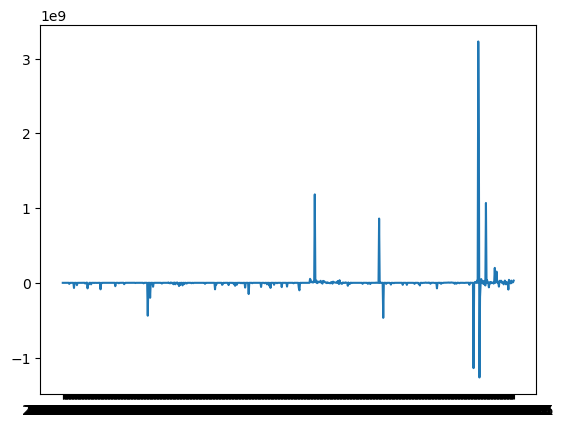

In [83]:
createPlotFromDict(dateTo_buyAndSellVolume)

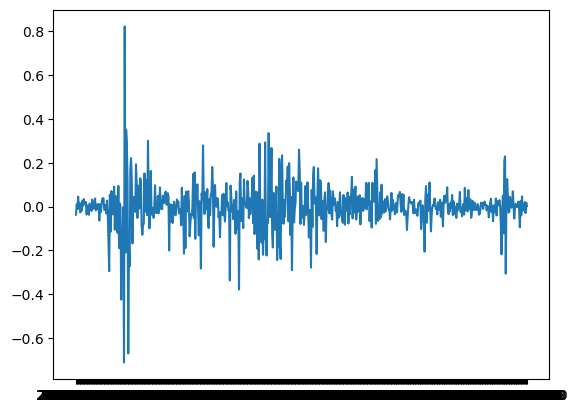

In [84]:
createPlotFromDict(dailyTokenPriceAction)

765 640


ValueError: x and y must be the same size

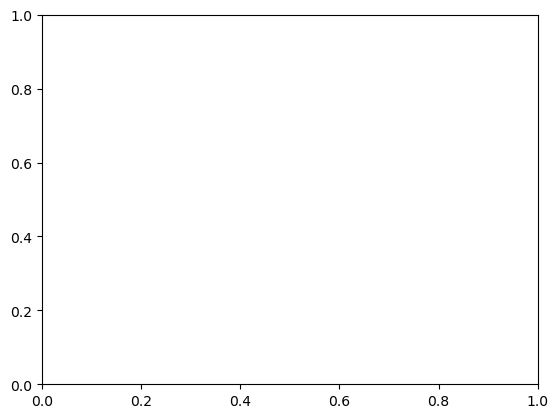

In [85]:
print(len(dateTo_buyAndSellVolume.values()), len(dailyTokenPriceAction.values()))

plt.scatter(dateTo_buyAndSellVolume.values(), dailyTokenPriceAction.values())
plt.show

In [ ]:
def performLinearRegression(data1, data2):
    a = list(data1.values())
    b = list(data2.values())

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(a, b)
    
    print("R_value:",r_value**2)
    print("P_value:",p_value)

In [ ]:
performLinearRegression(dailyTransactionVolume, dailyTokenPriceAction)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 210 and the array at index 1 has size 182

- transaction volume per day vs the price per day